In [1]:
import torch
import torchvision
from torchvision.models.detection import maskrcnn_resnet50_fpn
from torchvision.models.detection import MaskRCNN_ResNet50_FPN_Weights

# En iyi güncel ağırlıkları (COCO veri seti) kullan
weights = MaskRCNN_ResNet50_FPN_Weights.DEFAULT
model = maskrcnn_resnet50_fpn(weights=weights)

model.eval() # Test/Inference moduna al

Downloading: "https://download.pytorch.org/models/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth" to /root/.cache/torch/hub/checkpoints/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth
100%|██████████| 170M/170M [00:00<00:00, 221MB/s] 


MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(in

In [5]:
!wget "https://ichef.bbci.co.uk/ace/ws/800/cpsprodpb/128F1/production/_101971067_gettyimages-933565210.jpg.webp"

--2025-12-11 16:48:35--  https://ichef.bbci.co.uk/ace/ws/800/cpsprodpb/128F1/production/_101971067_gettyimages-933565210.jpg.webp
Resolving ichef.bbci.co.uk (ichef.bbci.co.uk)... 184.28.148.150, 2600:1406:3a00:68b::f33, 2600:1406:3a00:691::f33, ...
Connecting to ichef.bbci.co.uk (ichef.bbci.co.uk)|184.28.148.150|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 59654 (58K) [image/webp]
Saving to: ‘_101971067_gettyimages-933565210.jpg.webp’

_101971067_gettyima 100%[===================>]  58.26K  --.-KB/s    in 0.04s   

2025-12-11 16:48:35 (1.49 MB/s) - ‘_101971067_gettyimages-933565210.jpg.webp’ saved [59654/59654]



In [6]:
!ls /kaggle/working/

 _101971067_gettyimages-933565210.jpg.webp
'visual-question-answering-aa6ecaa14a.jpg?auto=format&fit=max&w=3840'


In [11]:
from torchvision.utils import draw_bounding_boxes
from torchvision.io import read_image
import matplotlib.pyplot as plt
from torchvision.transforms import functional as F

#Örnek bir resim okuyalım (Kendi resim yolunuzu verin)
img = read_image("_101971067_gettyimages-933565210.jpg.webp") 

img = F.convert_image_dtype(img, dtype=torch.float)
# Model tahmini (Liste içinde tensör ister)
predictions = model([img])

# İlk resmin tahminlerine bakalım
pred = predictions[0]

print("Tespit edilen kutu sayısı:", len(pred['boxes']))
print("Skorlar:", pred['scores'][:5]) # İlk 5 skor
print("Maske boyutu:", pred['masks'].shape) 
# Çıktı Örneği: [N, 1, H, W] -> N adet nesne için HxW maske

Tespit edilen kutu sayısı: 24
Skorlar: tensor([0.9998, 0.9997, 0.9997, 0.9992, 0.9991], grad_fn=<SliceBackward0>)
Maske boyutu: torch.Size([24, 1, 450, 800])


Eşik değerinden (0.7) sonra kalan nesne sayısı: 7


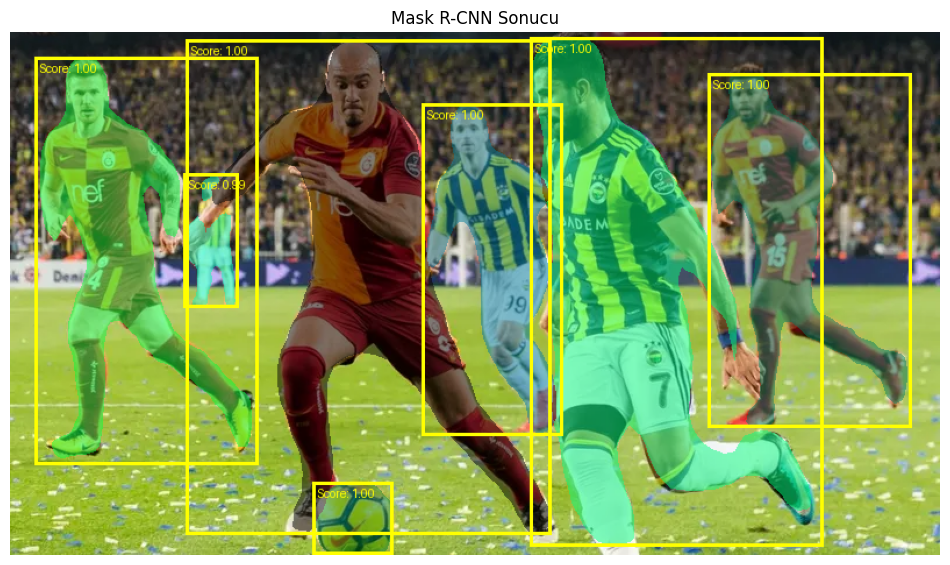

In [17]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torchvision.utils import draw_segmentation_masks, draw_bounding_boxes

# --- 1. Adım: Düşük skorlu tahminleri eleyelim (Thresholding) ---
score_threshold = 0.7  # %70'in altındaki tahminleri gösterme
keep_idx = pred['scores'] > score_threshold

# Sadece güvenilir olanları filtrele
filtered_boxes = pred['boxes'][keep_idx]
filtered_masks = pred['masks'][keep_idx]
filtered_scores = pred['scores'][keep_idx]
filtered_labels = [f"Score: {s:.2f}" for s in filtered_scores] # Etiket olarak skorları yazalım

print(f"Eşik değerinden ({score_threshold}) sonra kalan nesne sayısı: {len(filtered_boxes)}")

# --- 2. Adım: Görüntü Tipini Ayarlama ---
# Çizim fonksiyonları (draw_...) genelde uint8 (0-255) bekler.
# Elimizdeki 'img' (0-1 float) olduğu için geri çeviriyoruz.
img_uint8 = (img * 255).to(dtype=torch.uint8)

# --- 3. Adım: Maskeleri Hazırlama ---
# Mask R-CNN 0 ile 1 arası olasılık (soft mask) döndürür.
# Bunları True/False (boolean) formatına çevirmeliyiz.
# Ayrıca şekli [N, 1, H, W] -> [N, H, W] yapmalıyız (.squeeze(1))
bool_masks = filtered_masks > 0.5 
bool_masks = bool_masks.squeeze(1)

# --- 4. Adım: Çizim İşlemi ---
# Önce maskeleri çiz (alpha=0.5 şeffaflık sağlar)
output_with_masks = draw_segmentation_masks(image=img_uint8, 
                                            masks=bool_masks, 
                                            alpha=0.5)

# Üzerine kutuları çiz (colors='red' diyerek kutuları kırmızı yapalım)
output_final = draw_bounding_boxes(image=output_with_masks, 
                                   boxes=filtered_boxes, 
                                   labels=filtered_labels,
                                   colors="yellow",
                                   width=3)

# --- 5. Adım: Ekranda Gösterme ---
plt.figure(figsize=(12, 8))
# Torch tensörü (C, H, W) formatındadır, Matplotlib (H, W, C) ister. 
# .permute(1, 2, 0) ile yer değiştiriyoruz.
plt.imshow(output_final.permute(1, 2, 0).numpy())
plt.axis('off') # Eksenleri kapat
plt.title("Mask R-CNN Sonucu")
plt.show()

Keypoint R-CNN

Downloading: "https://download.pytorch.org/models/keypointrcnn_resnet50_fpn_coco-fc266e95.pth" to /root/.cache/torch/hub/checkpoints/keypointrcnn_resnet50_fpn_coco-fc266e95.pth
100%|██████████| 226M/226M [00:01<00:00, 229MB/s] 


Tespit edilen kişi sayısı: 9


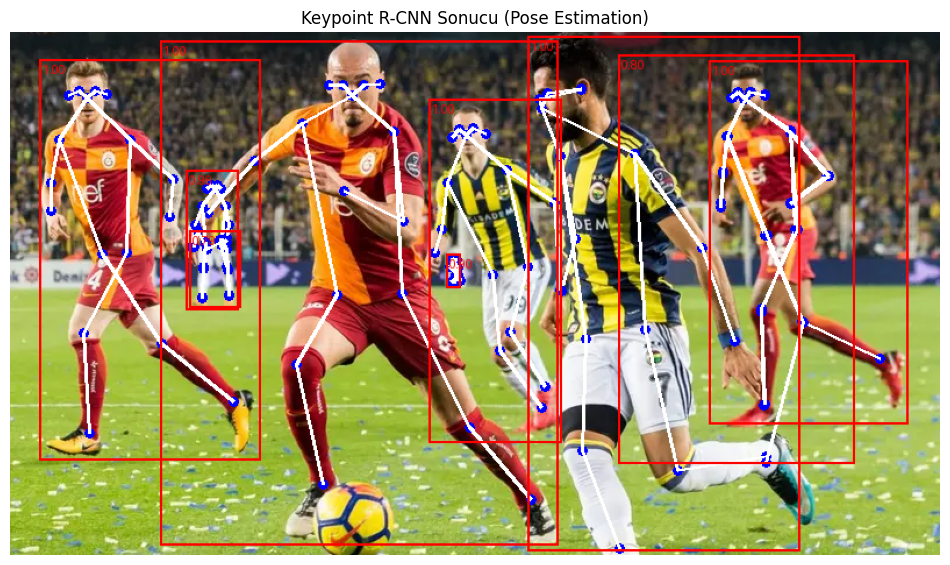

In [18]:
import torch
import matplotlib.pyplot as plt
from torchvision.models.detection import keypointrcnn_resnet50_fpn, KeypointRCNN_ResNet50_FPN_Weights
from torchvision.utils import draw_keypoints, draw_bounding_boxes

# --- 1. Keypoint Modelini Yükle ---
# COCO veri seti üzerinde eğitilmiş ağırlıkları kullanıyoruz
weights = KeypointRCNN_ResNet50_FPN_Weights.DEFAULT
model_kp = keypointrcnn_resnet50_fpn(weights=weights)
model_kp.eval()

# --- 2. Tahmin Yap ---
# img daha önceki adımdan geliyor (Float Tensor [C, H, W])
# Batch boyutu ekleyerek modele veriyoruz
with torch.no_grad():
    predictions = model_kp([img])

pred = predictions[0]

# --- 3. Filtreleme (Threshold) ---
score_threshold = 0.7
keep_idx = pred['scores'] > score_threshold

filtered_boxes = pred['boxes'][keep_idx]
filtered_keypoints = pred['keypoints'][keep_idx]
filtered_scores = pred['scores'][keep_idx]

print(f"Tespit edilen kişi sayısı: {len(filtered_boxes)}")

# --- 4. Görselleştirme Hazırlığı ---

# Çizim fonksiyonları uint8 bekler, float görüntüyü çeviriyoruz
img_uint8 = (img * 255).to(dtype=torch.uint8)

# İskelet bağlantılarını tanımlayalım (COCO standartlarına göre noktaları birleştirir)
# Bu liste noktaların (örneğin dirsek ile bilek) çizgiyle bağlanmasını sağlar.
coco_skeleton = [
    (0, 1), (0, 2), (1, 3), (2, 4), (0, 5), (0, 6), (5, 7), (6, 8),
    (7, 9), (8, 10), (5, 11), (6, 12), (11, 13), (12, 14), (13, 15), (14, 16)
]

# Önce Keypoint'leri (noktaları ve çizgileri) çiz
output_image = draw_keypoints(
    img_uint8, 
    filtered_keypoints, 
    connectivity=coco_skeleton, 
    colors="blue", 
    radius=4, 
    width=3
)

# Üzerine kutuları çiz
output_final = draw_bounding_boxes(
    output_image, 
    filtered_boxes, 
    labels=[f"{s:.2f}" for s in filtered_scores],
    colors="red",
    width=2
)

# --- 5. Ekrana Bas ---
plt.figure(figsize=(12, 8))
plt.imshow(output_final.permute(1, 2, 0).numpy())
plt.axis('off')
plt.title("Keypoint R-CNN Sonucu (Pose Estimation)")
plt.show()